<a href="https://colab.research.google.com/github/yogapramudana18/Image-Classification---Transfer-Learning-CNN/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jcopdl
!pip install gdown

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16923 sha256=d29f772103173703bfc9c120bd714f3e37f0eb949d95cfe7d4236a907c0e618a
  Stored in directory: /root/.cache/pip/wheels/e5/78/9d/931694cba38491e16f1a94719193211fd12a7307570d9bb562
Successfully built jcopdl


In [ ]:
!gdown https://drive.google.com/uc?id=18tm8JEVPTxAyC3lpVddos43hf9yx95v3

In [ ]:
!unzip /content/data.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset dan Dataloader

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7,1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder("Train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("Test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)

In [ ]:
feature, target = next(iter(trainloader))
feature.shape, target.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [ ]:
label2cat = train_set.classes
label2cat

['boys', 'girls']

# Arsitektur dan Config

In [ ]:
from torchvision.models import mobilenet_v2

mnet = mobilenet_v2(pretrained=True)

for param in mnet.parameters():
    param.requires_grad = False
    
mnet

In [ ]:
class CustomMobilenetv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, 2),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in mnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in mnet.parameters():
            param.requires_grad = True

In [ ]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

# Training

## Fase 1: Adaptasi (lr standard + patience kecil) / kepala klasifikasi saja

In [ ]:
model = CustomMobilenetv2().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model", early_stop_patience=2)

In [ ]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test:   0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


Epoch     1
Train_cost  = 0.2999 | Test_cost  = 0.8458 | Train_score = 0.8794 | Test_score = 0.8302 |


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train:   0%|          | 0/28 [00:00<?, ?it/s]

    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_wor

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.2096 | Test_cost  = 0.2487 | Train_score = 0.9250 | Test_score = 0.9168 |


Train:   0%|          | 0/28 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1819 | Test_cost  = 0.4119 | Train_score = 0.9313 | Test_score = 0.9064 |
==> EarlyStop patience =  1 | Best test_score: 0.9168


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train:   0%|          | 0/28 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1423 | Test_cost  = 0.5104 | Train_score = 0.9544 | Test_score = 0.8371 |
==> EarlyStop patience =  2 | Best test_score: 0.9168
==> Execute Early Stopping at epoch: 4 | Best test_score: 0.9168
==> Best model is saved at model


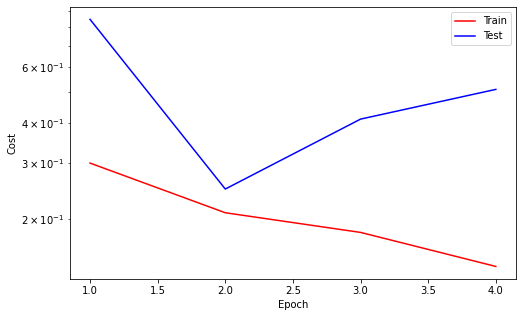

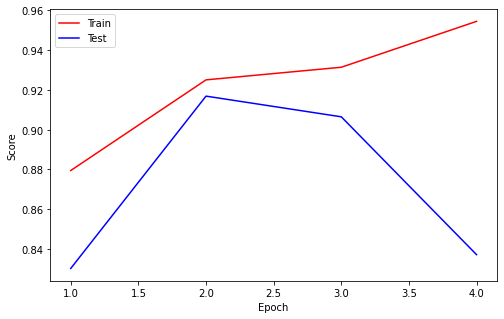

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Fase 2: Fine Tuning (lr dikecilin, patience ditambah)

In [ ]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

Train:   0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1423 | Test_cost  = 0.2328 | Train_score = 0.9475 | Test_score = 0.9203 |


Train:   0%|          | 0/28 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1223 | Test_cost  = 0.2360 | Train_score = 0.9585 | Test_score = 0.9255 |


Train:   0%|          | 0/28 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1078 | Test_cost  = 0.2438 | Train_score = 0.9648 | Test_score = 0.9203 |
==> EarlyStop patience =  1 | Best test_score: 0.9255


Train:   0%|          | 0/28 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho


Epoch     8
Train_cost  = 0.1010 | Test_cost  = 0.2343 | Train_score = 0.9636 | Test_score = 0.9237 |
==> EarlyStop patience =  2 | Best test_score: 0.9255


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Train:   0%|          | 0/28 [00:00<?, ?it/s]

    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


Epoch     9
Train_cost  = 0.1105 | Test_cost  = 0.2294 | Train_score = 0.9585 | Test_score = 0.9237 |
==> EarlyStop patience =  3 | Best test_score: 0.9255


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd78a43f290>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Train:   0%|          | 0/28 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1034 | Test_cost  = 0.2453 | Train_score = 0.9636 | Test_score = 0.9237 |
==> EarlyStop patience =  4 | Best test_score: 0.9255


Train:   0%|          | 0/28 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1061 | Test_cost  = 0.2354 | Train_score = 0.9613 | Test_score = 0.9237 |
==> EarlyStop patience =  5 | Best test_score: 0.9255
==> Execute Early Stopping at epoch: 11 | Best test_score: 0.9255
==> Best model is saved at model


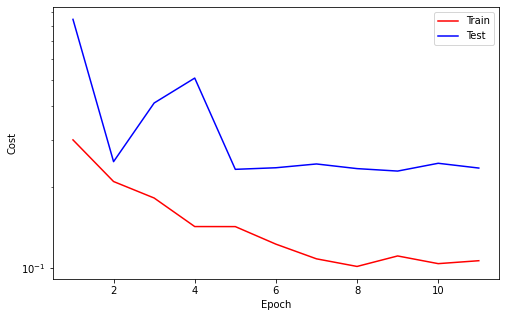

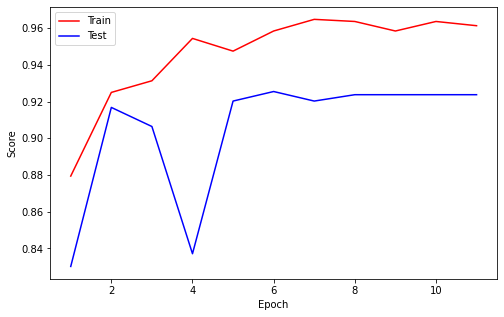

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

bs = 100
crop_size = 224

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validate_set = datasets.ImageFolder("data/Test/", transform=test_transform)
validateloader = DataLoader(validate_set, batch_size=bs, shuffle=True, num_workers=2)

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')

# Sanity Check

In [ ]:
def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

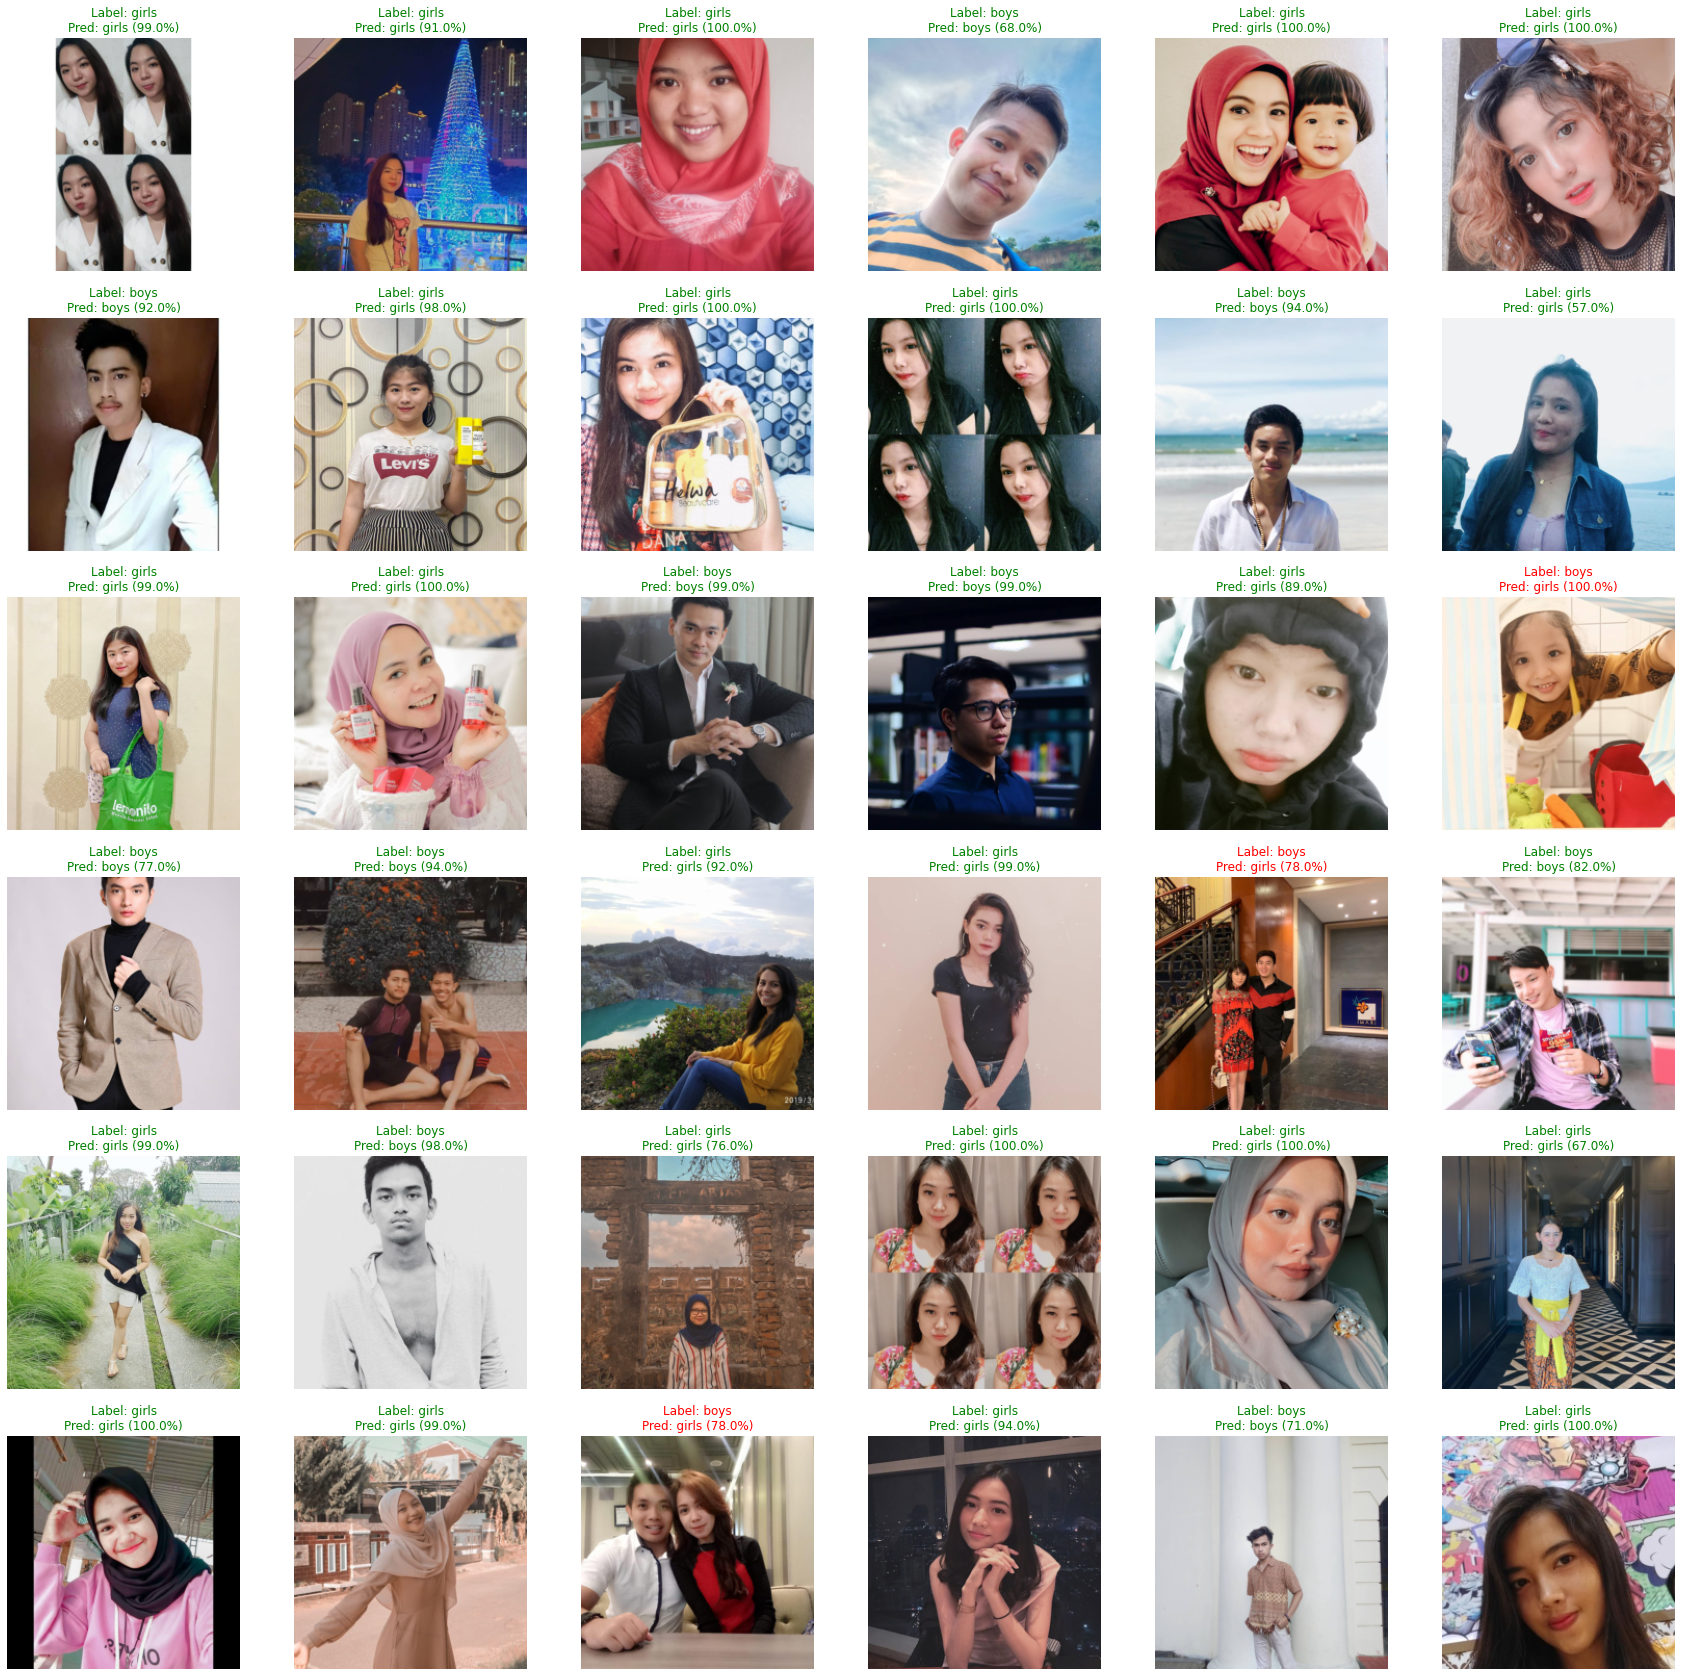

In [ ]:
fig, axes = plt.subplots(6,6, figsize=(30,30))
for img, label, pred, prob, ax, i in zip(feature, target, preds, output, axes.flatten(), range(36)):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color": "g"} if (label == pred) else {"color": "r"}
    label, pred, prob = label2cat[label.item()], label2cat[pred.item()], torch.round(torch.exp(output[i,pred.item()])*100)
    ax.set_title(f"Label: {label}\nPred: {pred} ({prob}%)", fontdict=font)
    ax.axis('off');

In [ ]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/logs.pth (deflated 36%)
  adding: content/model/weights_best.pth (deflated 8%)
  adding: content/model/configs.pth (deflated 54%)
